In [1]:
import random
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

SEED = 515
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

# Load Data

In [2]:
import unicodedata
import string
import os
import glob

all_letters = string.ascii_letters + " .,;'-"
# Plus EOS marker
n_letters = len(all_letters) + 1

def unicode2ascii(s):
    """
    Mapping unicode characters to ascii characters. 
    """
    return ''.join([c for c in unicodedata.normalize('NFD', s) if unicodedata.category(c) != 'Mn' and c in all_letters])

unicode2ascii("O'Néàl")

"O'Neal"

In [3]:
category_lines = {}
all_categories = []
for fn in glob.iglob("../assets/data/names/*.txt"):
    category = os.path.basename(fn).replace('.txt', '')
    all_categories.append(category)    
    with open(fn, encoding='utf-8') as f:
        category_lines[category] = [unicode2ascii(line) for line in f]
    
n_categories = len(all_categories)

print(n_categories)
print(all_categories)

18
['Dutch', 'Greek', 'Japanese', 'Portuguese', 'Spanish', 'French', 'Scottish', 'Czech', 'Vietnamese', 'Italian', 'Chinese', 'Polish', 'Irish', 'Korean', 'Arabic', 'Russian', 'English', 'German']


In [4]:
def category2tensor(category):
    tensor = torch.zeros(1, n_categories)
    tensor[0][all_categories.index(category)] = 1
    return tensor

category2tensor('Chinese')

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.]])

In [5]:
def line2input_tensor(line):
    """
    Transforming a sentence to a <line length x 1 x n_letters> tensor of one-hot embeddings. 
    From the 1st to the last letter (NOT including EOS). 
    """
    tensor = torch.zeros(len(line), 1, n_letters)
    for i, letter in enumerate(line):
        tensor[i, 0, all_letters.index(letter)] = 1
    return tensor

line2input_tensor('Jones')

tensor([[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       

In [6]:
def line2target_tensor(line):
    """
    Transforming a sentence to a <line length> tensor of letter-indexes. 
    From the 2nd letter to the end (EOS). 
    """
    letter_indexes = [all_letters.index(letter) for letter in line[1:]]
    letter_indexes.append(n_letters - 1) # EOS
    return torch.tensor(letter_indexes)

line2target_tensor('Jones')

tensor([14, 13,  4, 18, 58])

In [7]:
def random_cate_name():
    cate = np.random.choice(all_categories)
    name = np.random.choice(category_lines[cate])
    return cate, name

random_cate_name()

('Italian', 'Leoni')

# Define Model

In [8]:
class NameGenerator(nn.Module):
    def __init__(self, in_size, hidden_size, out_size, n_categories):
        super(NameGenerator, self).__init__()
        self.hidden_out_size = hidden_size + out_size

        # NOTE: Slightly different from the specification in the tutorial, as 
        # the real hidden size is (hidden_size + out_size) here. 
        # self.rnn = nn.RNN(n_categories + in_size, hidden_size + out_size)
        self.rnn = nn.GRU(n_categories + in_size, hidden_size + out_size)
        self.fc = nn.Linear(hidden_size + out_size, out_size)
        
    def forward(self, cate_emb, name_emb):
        """
        cate_emb: (1 * n_cate)
        name_emb: (n_chars * 1 * n_letters)
        """
        hidden_out0 = torch.zeros(1, 1, self.hidden_out_size)

        # cate_name_emb: (n_chars * 1 * (n_cate + n_letters))
        cate_name_emb = torch.cat([cate_emb.repeat([name_emb.size(0), 1, 1]), name_emb], dim=-1)
        # hidden_outs: (n_chars * 1 * (n_hidden + n_letters))
        hidden_outs, _ = self.rnn(cate_name_emb, hidden_out0)
        # hidden_outs: (n_chars * (n_hidden + n_letters))
        hidden_outs = hidden_outs.view(-1, self.hidden_out_size)
        # outs: (n_chars * n_letters)
        outs = self.fc(hidden_outs)
        outs = F.dropout(outs, p=0.1)
        return F.log_softmax(outs, dim=-1)

    def generate(self, cate_emb, name_emb, n_letters, max_len=20):
        """
        cate_emb: (1 * n_cate)
        name_emb: (n_chars * 1 * n_letters)
        """
        hidden_out0 = torch.zeros(1, 1, self.hidden_out_size)

        # cate_name_emb: (n_chars * 1 * (n_cate + n_letters))
        cate_name_emb = torch.cat([cate_emb.repeat([name_emb.size(0), 1, 1]), name_emb], dim=-1)
        # hidden_outs: (n_chars * 1 * (n_hidden + n_letters))
        # this_hidden_out: (1 * 1 * (n_hidden + n_letters))
        hidden_outs, this_hidden_out = self.rnn(cate_name_emb, hidden_out0)

        li_list = []
        for i in range(max_len - hidden_outs.size(0)):
            # this_out: (1 * n_letters)
            this_out = self.fc(this_hidden_out.view(-1, self.hidden_out_size))
            # torch.topk: The last dimension is chosen by default. 
            # torch.argmax: The argmax of the flattened input is returned by default. 
            _, next_li = F.log_softmax(this_out).topk(1)
            next_li = next_li.item()
            # EOS
            if next_li == n_letters-1:
                break
            
            li_list.append(next_li)

            # Create the next tensor
            next_l_emb = torch.zeros(1, 1, n_letters)
            next_l_emb[0, 0, next_li] = 1
            next_cate_l_emb = torch.cat([cate_emb.view(1, 1, -1), next_l_emb], dim=-1)
            _, this_hidden_out = self.rnn(next_cate_l_emb, this_hidden_out)
            
        return li_list

In [9]:
n_hidden = 128
NG = NameGenerator(n_letters, n_hidden, n_letters, n_categories)

cate, name = random_cate_name()
print(cate, name)

cate_emb = category2tensor(cate)
name_emb = line2input_tensor(name)
scores = NG(cate_emb, name_emb)

scores.size()

Polish Sokolsky


torch.Size([8, 59])

In [10]:
# NOTE: The default reduction of nn.NLLLoss is "mean". 
# The essence of the NLL-loss in the tutorial has the reduction of "sum", actually. 
loss_func = nn.NLLLoss(reduction='sum')

target = line2target_tensor(name)
loss_func(scores, target)

tensor(32.6363, grad_fn=<NllLossBackward>)

In [11]:
NG.generate(cate_emb, name_emb, n_letters)

[38, 38, 38, 38, 30, 45, 45, 36, 36, 36, 36, 36]

# Train Model

In [12]:
import time
import math

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

In [13]:
# optimizer = optim.SGD(NG.parameters(), lr=0.0005)
optimizer = optim.Adadelta(NG.parameters(), lr=1.0, rho=0.95)

n_iters = 100000
print_every = 5000
plot_every = 500
all_losses = []
total_loss = 0 # Reset every plot_every iters

start = time.time()

for i in range(1, n_iters+1):
    cate, name = random_cate_name()

    # Forward pass
    cate_emb = category2tensor(cate)
    name_emb = line2input_tensor(name)
    target = line2target_tensor(name)
    scores = NG(cate_emb, name_emb)

    # Calculate loss
    loss = loss_func(scores, target)
    total_loss += (loss.item() / len(name))

    # Backward propagation
    optimizer.zero_grad()
    loss.backward()

    # Update weights
    optimizer.step()

    if i % print_every == 0:
        print('%s (%d %d%%) %.4f' % (timeSince(start), i, i / n_iters * 100, total_loss / plot_every))

    if i % plot_every == 0:
        all_losses.append(total_loss / plot_every)
        total_loss = 0

0m 20s (5000 5%) 2.3281
0m 41s (10000 10%) 2.0715
1m 3s (15000 15%) 2.0058
1m 24s (20000 20%) 1.8798
1m 45s (25000 25%) 1.8424
2m 5s (30000 30%) 1.7423
2m 26s (35000 35%) 1.7538
2m 48s (40000 40%) 1.6765
3m 15s (45000 45%) 1.6546
3m 42s (50000 50%) 1.6199
4m 7s (55000 55%) 1.5457
4m 33s (60000 60%) 1.6211
4m 59s (65000 65%) 1.5447
5m 27s (70000 70%) 1.5739
5m 54s (75000 75%) 1.5720
6m 20s (80000 80%) 1.4923
6m 45s (85000 85%) 1.4684
7m 10s (90000 90%) 1.5174
7m 36s (95000 95%) 1.4991
8m 1s (100000 100%) 1.5074


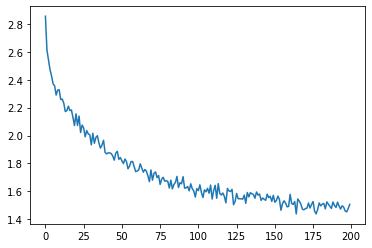

In [14]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(all_losses)

# Sampling the Network

In [15]:
def sample(cate, start='A', max_len=20):
    with torch.no_grad():
        cate_emb = category2tensor(cate)
        name_emb = line2input_tensor(start)
        li_list = NG.generate(cate_emb, name_emb, n_letters, max_len=max_len)
        
    return start + "".join([all_letters[li] for li in li_list])



max_len = 20
NG.eval()

print([sample('Russian', start) for start in 'RUS'])
print([sample('German', start) for start in 'GER'])
print([sample('Spanish', start) for start in 'SPA'])
print([sample('English', start) for start in 'ENG'])
print([sample('Chinese', start) for start in 'CHI'])

['Rudamakin', 'Uran', 'Shinov']
['Grost', 'Est', 'Romen']
['Santiago', 'Pareio', 'Alves']
['Essley', 'Nigger', 'Gander']
['Chu', 'Huo', 'Ins']


In [16]:
with torch.no_grad():
    cate, name = random_cate_name()
    print(cate, name)

    cate_emb = category2tensor(cate)
    name_emb = line2input_tensor(name)

    li_list = NG(cate_emb, name_emb).argmax(dim=-1)
    print(li_list)
    print(name[0] + "".join([all_letters[li] if li < n_letters-1 else '<EOS>' for li in li_list]))

German Knef
tensor([14,  4,  8, 58])
Koei<EOS>
